## design leader sequence

In [84]:
import infrared as ir
import infrared.rna as rna
import RNA
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [85]:
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

In [86]:
AROA_seq =  'AGUCAGGCCGCCACCGGAUAAAGGUAGACGGUGCUGCCUGCAACCUUUCU'
AROA_ss = [ "...(((((...(((((............)))))..)))))..........",
            "...................((((((.................))))))..",
            "((...............................))..............."
]

In [87]:
# sequences for Leipzig
seq_07_10 = 'AGUCAGGCCGGG-UCC-----CCCGCCACGUGGAG------CCCU----UA---UCCGCGUGCUGCCUGU---------AGGGAA'
seq_07_08 = 'AGUCAGGCCCGG-UUAGU---CCGGCCACCGGUAUCCCUUCCUCCA---U----UACCGGUGCUGCCUG---------UGGAGAA'

# sequences from new designs
design2 = 'UGUCAGGCCUAG-GAAAAGA-CUAGCCACGGAU--------GCGUUC--A-----AUUCGUGCAGCCUGUUU-----GAGUGUUU'
design3 = 'UGUCAGGCCUCG-UCCAGU--CGAGCCACGUGCC-------GGUCCG--A----GGUACGUGCAGCCUGUUUUUC--CGGAUUUU'
design7 = 'UGUCAGGCCCUC-GUUCA---GAGGCCACGUCU-A------GAG-----CAAAA-AGACGUGCAGCCUGUU---------UUUUU'
design10 =  'UGUCAGGCCUCUGUAAC---CAGAGCCACGUGU--------UUUAACAUU-----GCACGUGCAGCCUGUUUUU-AUGUUAAGUC'

In [88]:
# insert sequence to create leader for
seq = design2


In [89]:
structures = ['...((((((((((.......))))).((((((((....................))))))))..)))))................',
		      '((............................................................)).....................',
		      '.........................................((((((((..........................))))))))..']


xrRNA_ss = [remove_positioned_gaps(seq, s) for s in structures]
xrRNA_seq = seq.replace('-','')
print(xrRNA_seq)
for ss in xrRNA_ss:
    print(ss)

UGUCAGGCCUAGGAAAAGACUAGCCACGGAUGCGUUCAAUUCGUGCAGCCUGUUUGAGUGUUU
...(((((((((.......)))).(((((((.......)))))))..)))))...........
((...........................................))................
...............................((((((..................))))))..


In [90]:
extended_iupac_nucleotides = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'U': 'U',
    'R': 'AG',
    'N': 'ACGU',
    'X': 'ACGU-',
    '-': '-',
    '.': '-'
}

# convert extended iupac nts to RNA nts
def iupacvalues(symbol):
    return [ rna.nucleotide_to_value(x) for x in extended_iupac_nucleotides[symbol] ]

# convert IR sample to RNA sequence
def sample_to_seq(sample):
    return rna.values_to_seq(sample.values())

# calculate GC content of seq
def calculate_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq)

# calculate target frequency of given sequence and ss
def target_frequency(sequence, ss):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(ss)

# check if secondary structure is unpaired in the beginning
def acceptable_seq(ss):
    if not ss.startswith('........'):
        return False
    return True

In [91]:
# test suboptimal secondary structures and check if they interfere with xrRNA structure or unpaired region of the leader
def test_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss):
    target_ss = remove_positioned_gaps(leader_seq, target)
    target_ss = target_ss + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq

    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    strikes = 0
    for s in fc.subopt(500):
        if s.structure[len(leader_seq):] != xrRNA_ss or not s.structure.startswith('.....'):
            return False
    return True

# print suboptimal secondary structures
def print_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss, sample_size=1000):
    ss_leader = remove_positioned_gaps(leader_seq, target)
    target_ss = ss_leader + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq
    
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    suboptimal_ss = []
    for s in fc.subopt(sample_size):
        if s.structure not in suboptimal_ss:
            print(seq)
            print(f"{s.structure}\t{s.energy:6.2f}")
            print(target_ss)
            print(f'{"-" * len(ss_leader) + "+" * len(xrRNA_seq)}\n')
            suboptimal_ss.append(s.structure)
    return True

# test wheter there are interactions between the xrRNA and leader structure
def test_interaction(leader_seq, xrRNA_seq, xrRNA_ss,threshold = 0.01):
    leader_seq = leader_seq.replace('-','')

    seq = leader_seq + xrRNA_seq
    fold_compound = RNA.fold_compound(seq)
    fold_compound.pf()
    base_pair_probs = np.array(fold_compound.bpp())
    for i in range(len(leader_seq)):
        for j in range(len(leader_seq), len(seq)):
            if base_pair_probs[i][j] > threshold:  # Adjust threshold as needed
                return False
    return True

In [92]:
## GCUAA stays unpaired, then adding helix to leader
target =         ".........((((((....))))))...."
iupac_sequence = 'GCUAANNNXNNNNNXNNNXXNNNNNNNXX'
n = len(target)
model = ir.Model()
model.add_variables(n, 5)

# add constraints to model
for i, x in enumerate(iupac_sequence):
    model.add_constraints(ir.ValueIn(i, iupacvalues(x)))
model.add_constraints(rna.BPComp(i,j) for (i,j) in rna.parse(target))
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')

# create potential leader samples
sample_size = 1000000
sampler = ir.Sampler(model)
# samples = [sample_to_seq(sampler.sample()) for _ in range(10000)]
sampler.set_target( 0.5 * n, 0.1 * n, 'gc' )
samples = [sample_to_seq(sampler.targeted_sample()) for _ in tqdm(range(sample_size))]

100%|██████████| 1000000/1000000 [00:55<00:00, 18012.26it/s]


In [93]:
# check all samples and save samples that are unpaired in the beginning (GCUAA)
ok_leader= []
for seq in tqdm(samples):
    seq_ = seq.replace('-','')
    fc  = RNA.fold_compound(seq_)
    (ss, mfe) = fc.mfe()
    # check if GCUAA of ss is unpaired
    if acceptable_seq(ss):
        ok_leader.append(seq)

100%|██████████| 1000000/1000000 [02:21<00:00, 7089.31it/s]


In [94]:
len(ok_leader)

407709

In [95]:
# # save good leader candidates based on the interaction between the ss of xrRNA and leader
# good_candidates = []
# for seq in tqdm(ok_leader):
#     if test_interaction(seq, xrRNA_seq, xrRNA_ss[0], 0.05):
#         good_candidates.append(seq)

In [96]:
# using one leader for AROA and design
# good_candidates_both = []
# good_candidates = []

# for seq in tqdm(ok_leader):
#     if test_interaction(seq, xrRNA_seq, xrRNA_ss[0], 0.05):
#         good_candidates.append(seq)
#         if test_interaction(seq, AROA_seq, AROA_ss[0], 0.05):
#             good_candidates_both.append(seq)


In [97]:
# go over all ok leader and save leader with best target frequency
# prints current 
best_seq = None
best_freq = 0
leader_n = len(ok_leader)
for i, seq in enumerate(ok_leader):
    target_ss = remove_positioned_gaps(seq, target)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)

    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
    print(f'Done: {i/leader_n:.4f}%\tbest TF: {best_freq:.2f}', end='\r')

In [98]:
best_seq

'GCUAAGUAACCCGGCGAUCGCUGGGAA--'

In [99]:
#good_candidates_stored = ['GCUAAUGUCGUUGGUCAAUUGCUAGCUAA', 'GCUAAACGCCCUCCUGAG-GGGGAGGAAAA', 'GCUAAAAAAGCCUCCGGGAAGGAGGCAA', 'GCUAAGAAAGGUGGCAACAGUCACCAA-A']
good_candidates_stored = ['GCUAAUUAAGCGAGCUCCUGUUCGCAA-G', 'GCUAAUAA-GUGGGGUUGACCCCACAA--']

In [100]:
best_seq = good_candidates_stored[-1]

In [101]:
best_seq = None
best_freq = 0
for seq in good_candidates:
    target_ss = remove_positioned_gaps(seq, target)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    # candidates_df.loc[len(candidates_df)+1] = [seq, cur_freq]

    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))

In [102]:
print_suboptimal_ss(best_seq, xrRNA_seq, xrRNA_ss[0], 400)


TypeError: 'NoneType' object is not iterable

GCUAAUGUCGUUGGUCAAUUGCUAGCUAAUGUCAGGCCUAGGAAAAGACUAGCCACGGAUGCGUUCAAUUCGUGCAGCCUGUUUGAGUGUUU
((...(((.(((((((..((.((((((.......)).)))).))..))))))).)))...)).....(((((.(((...))).))))).... (-22.70)
((...(((.(((((((..((.((((((.......)),}))).))..))))))).)))...)).....(((((.(({...})).))))).... [-23.92]
((...(((.(((((((..((.((((((.......)).)))).))..))))))).)))...)).....(((((.(((...))).))))).... {-22.70 d=7.21}
((...(((.(((((((..((.((((((.......)).)))).))..))))))).)))...)).....(((((.(((...))).))))).... {-22.70 MEA=80.96}
 frequency of mfe structure in ensemble 0.137143; ensemble diversity 11.31 


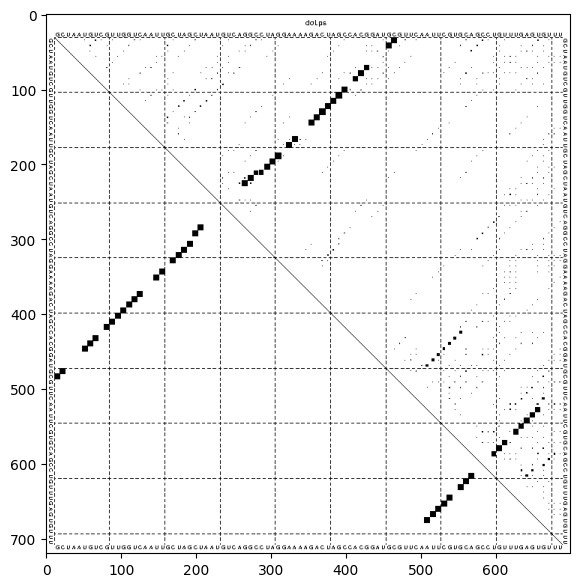

In [77]:
seq = best_seq.replace('-', '') + xrRNA_seq
!echo $seq > test.seq
!RNAfold -p --MEA < test.seq
#!convert dot.ps dot.png

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("dot.ps")
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA', '-structureDBN', '........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..', '-o', '/tmp/tmp274e0kpr.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#ff0000', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#008000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99']


Output file: /tmp/tmp274e0kpr.png



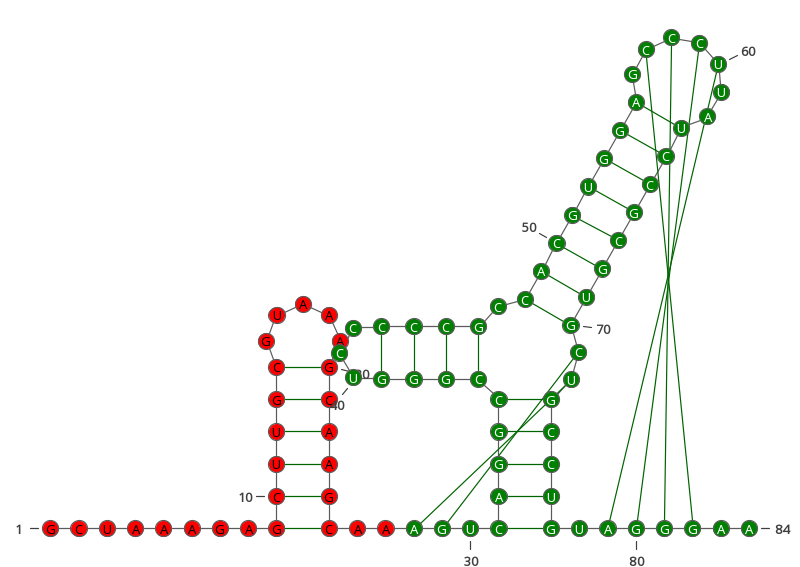

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA', '-structureDBN', '........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..', '-o', '/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#ff0000', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#008000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99']


Output file: /scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png



In [38]:
from varnaapi import Structure
import varnaapi
seq =  'GCUAAAGAGCUUGCGUAAAGCAAGCAAAGUCAGGCCGGGUCCCCCGCCACGUGGAGCCCUUAUCCGCGUGCUGCCUGUAGGGAA'
ss =  r'........((((((.....))))))..{{.(((((((((...)))).((((((((.[[[[..))))))))}}))))).]]]]..'
v = varnaapi.Structure(sequence=seq, structure=ss)
# .update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)


v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)
style_leader = varnaapi.param.BasesStyle(fill="red")
style_xrRNA = varnaapi.param.BasesStyle(fill="green")

v.add_bases_style(style_leader, list(range(1,28)))
v.add_bases_style(style_xrRNA, list(range(28,100)))

v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)

v.show()
# v.savefig('/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png')
